# Import necessary libraries

We need to import a library called [captcha](https://github.com/lepture/captcha/) to generate verification code.

The verification code we generate is composed of numbers and uppercase letters.

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [1]:
pip install captcha

  Using cached https://files.pythonhosted.org/packages/90/fe/d4ddf1e6576073b5eaea76e9b2afa022c626212a30c871968480be3ccb7b/captcha-0.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d6/98/0d360dbc087933679398d73187a503533ec0547ba4ffd2115365605559cc/Pillow-6.1.0-cp35-cp35m-manylinux1_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


Text(0.5, 1.0, 'CIXG')

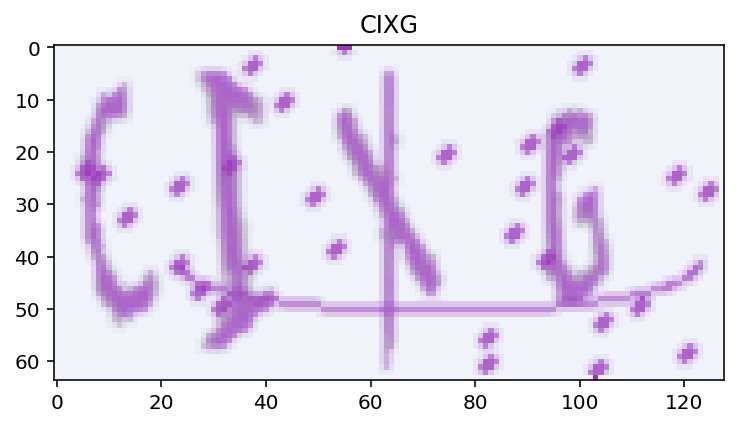

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
# print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

# Prevent tensorflow from taking up all memory

In [3]:
# import tensorflow as tf
# import tensorflow.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

# Define data generator

In [4]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

/home/m17626033168/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/m17626033168/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/m17626033168/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/m17626033168/.local/lib/python3.5/site-packages/tensorflow/python/f

# Test Generator

Text(0.5, 1.0, 'WZWB')

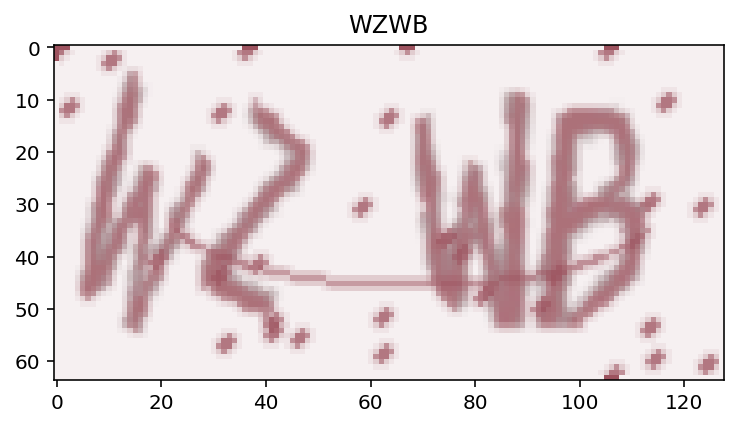

In [5]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

# print(characters)
data = CaptchaSequence(characters, batch_size=1, steps=1)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

# Define the structure of network

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

# Network structure visualization

We need to install the following libraries to visualize:

```sh
pip install pydot
sudo apt install graphviz
```

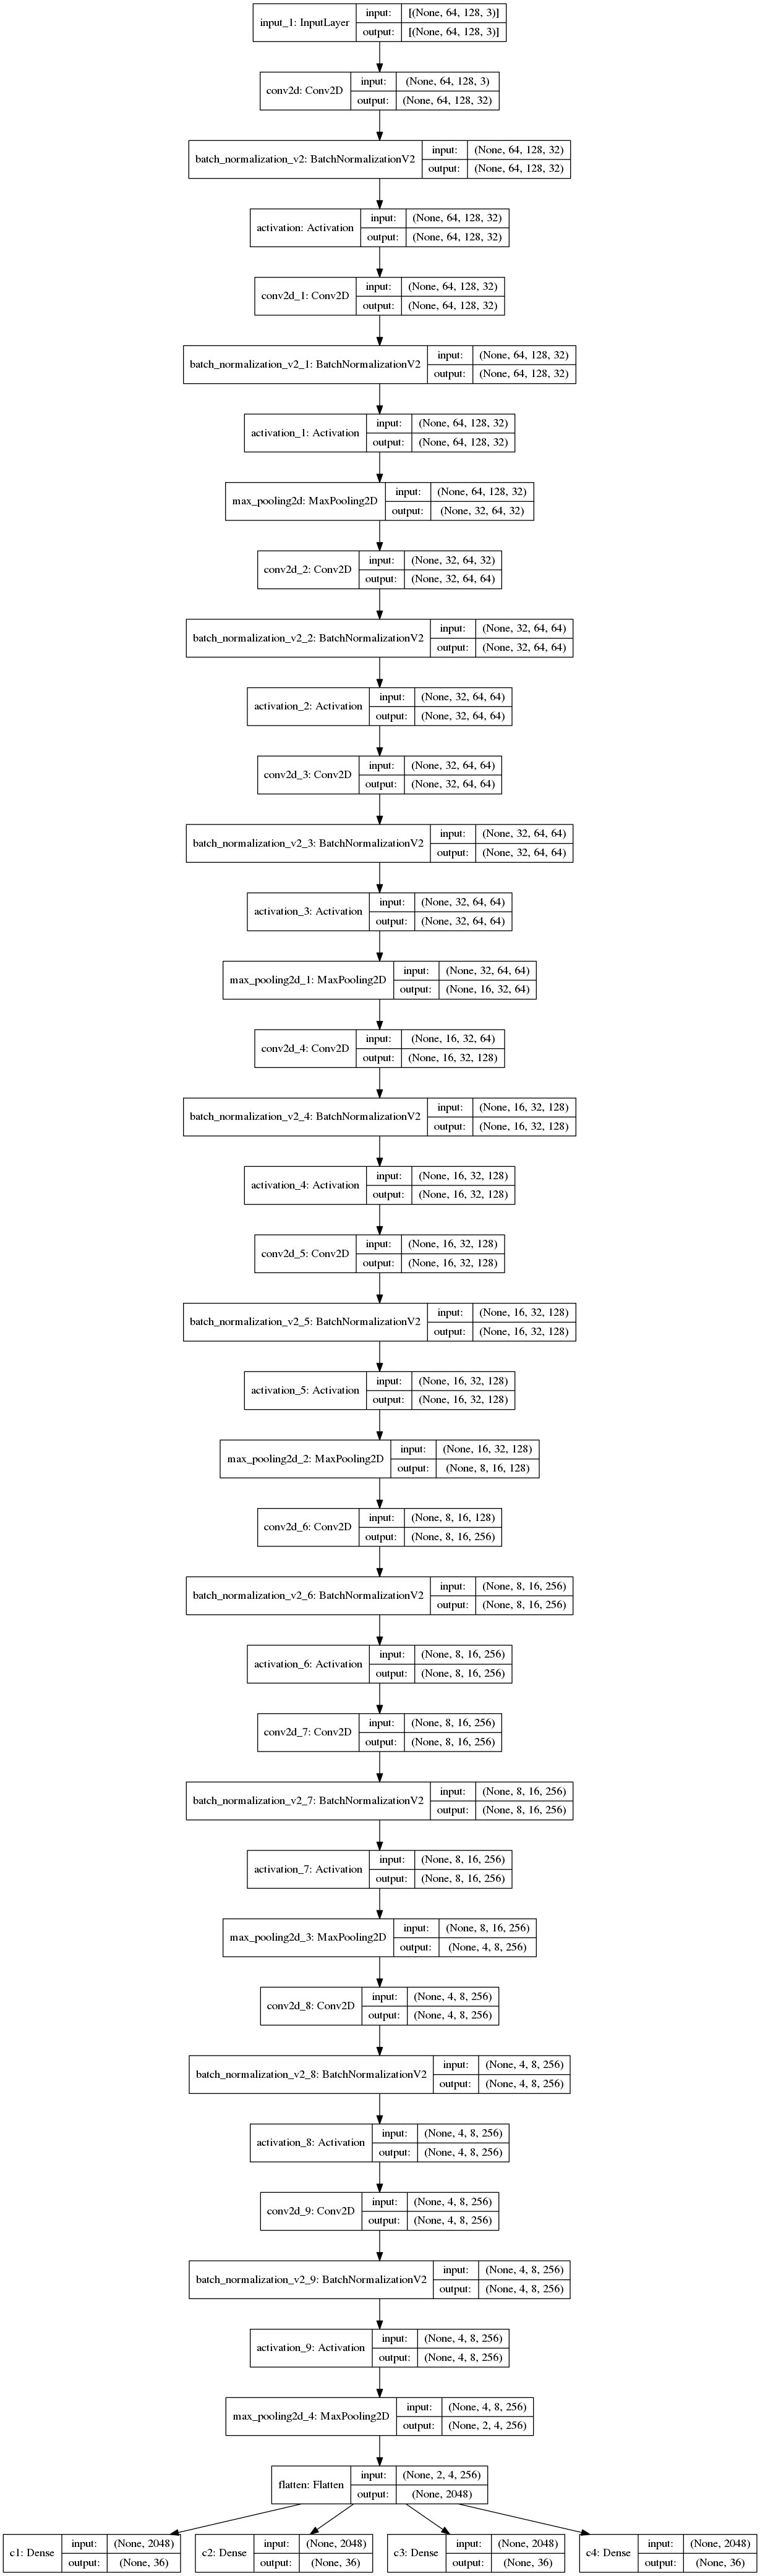

In [7]:
## 先空着 等会儿重启试一下
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 64, 128, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 128, 32)  0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

# Train the model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/100
1000/1000 [==============================] - 205s 205ms/step - loss: 4.8390 - c1_loss: 1.1522 - c2_loss: 1.2800 - c3_loss: 1.2731 - c4_loss: 1.1336 - c1_accuracy: 0.6781 - c2_accuracy: 0.6425 - c3_accuracy: 0.6450 - c4_accuracy: 0.6825 - val_loss: 0.7145 - val_c1_loss: 0.1384 - val_c2_loss: 0.2431 - val_c3_loss: 0.2216 - val_c4_loss: 0.1114 - val_c1_accuracy: 0.9554 - val_c2_accuracy: 0.9256 - val_c3_accuracy: 0.9303 - val_c4_accuracy: 0.9617
Epoch 2/100
1000/1000 [==============================] - 192s 192ms/step - loss: 0.2990 - c1_loss: 0.0613 - c2_loss: 0.0892 - c3_loss: 0.0877 - c4_loss: 0.0607 - c1_accuracy: 0.9764 - c2_accuracy: 0.9674 - c3_accuracy: 0.9683 - c4_accuracy: 0.9769 - val_loss: 0.7929 - val_c1_loss: 0.1340 - val_c2_loss: 0.2470 - val_c3_loss: 0.2327 - val_c4_loss: 0.1793 - val_c1_accuracy: 0.9530 - val_c2_accuracy: 0.9214 - val_c3_accuracy: 0.9280 - val_c4_accuracy: 0.9432
Epoch 3/100
1000/1000 [==============================] - 198s 198ms/step - loss: 0

In [10]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/100
1000/1000 [==============================] - 197s 197ms/step - loss: 0.0737 - c1_loss: 0.0165 - c2_loss: 0.0196 - c3_loss: 0.0197 - c4_loss: 0.0179 - c1_accuracy: 0.9934 - c2_accuracy: 0.9923 - c3_accuracy: 0.9920 - c4_accuracy: 0.9928 - val_loss: 0.0754 - val_c1_loss: 0.0162 - val_c2_loss: 0.0203 - val_c3_loss: 0.0224 - val_c4_loss: 0.0165 - val_c1_accuracy: 0.9933 - val_c2_accuracy: 0.9916 - val_c3_accuracy: 0.9913 - val_c4_accuracy: 0.9934
Epoch 2/100
1000/1000 [==============================] - 186s 186ms/step - loss: 0.0692 - c1_loss: 0.0163 - c2_loss: 0.0190 - c3_loss: 0.0194 - c4_loss: 0.0145 - c1_accuracy: 0.9934 - c2_accuracy: 0.9926 - c3_accuracy: 0.9925 - c4_accuracy: 0.9941 - val_loss: 0.0710 - val_c1_loss: 0.0166 - val_c2_loss: 0.0193 - val_c3_loss: 0.0186 - val_c4_loss: 0.0164 - val_c1_accuracy: 0.9926 - val_c2_accuracy: 0.9912 - val_c3_accuracy: 0.9934 - val_c4_accuracy: 0.9940
Epoch 3/100
1000/1000 [==============================] - 187s 187ms/step - loss: 0

In [11]:
model.load_weights('cnn_best.h5')

# Test the model

(-0.5, 127.5, 63.5, -0.5)

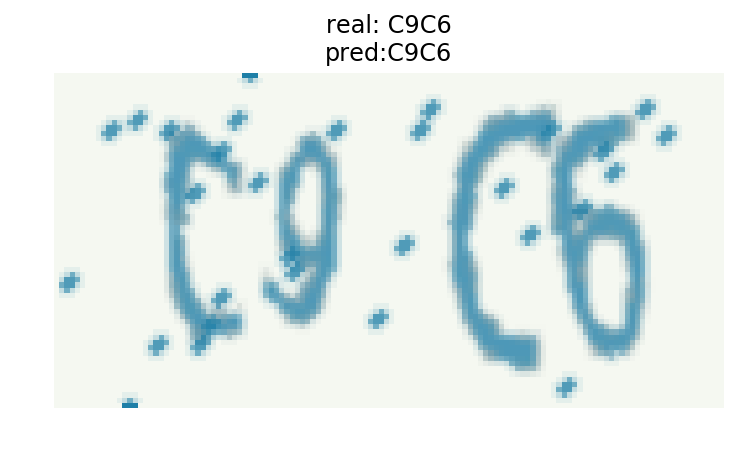

In [12]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# Calculate the accuracy of model

In [13]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


0.973203125

# Save the model

In [14]:
model.save('cnn.h5', include_optimizer=False)

# Visual training curve

```sh
pip install pandas
```

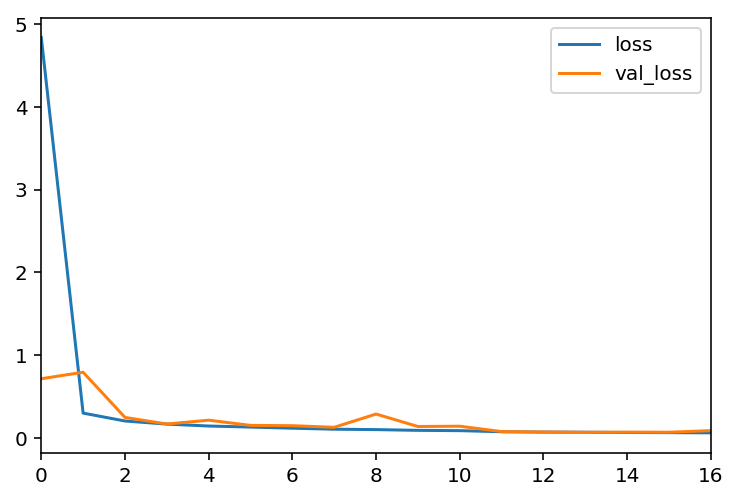

In [15]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

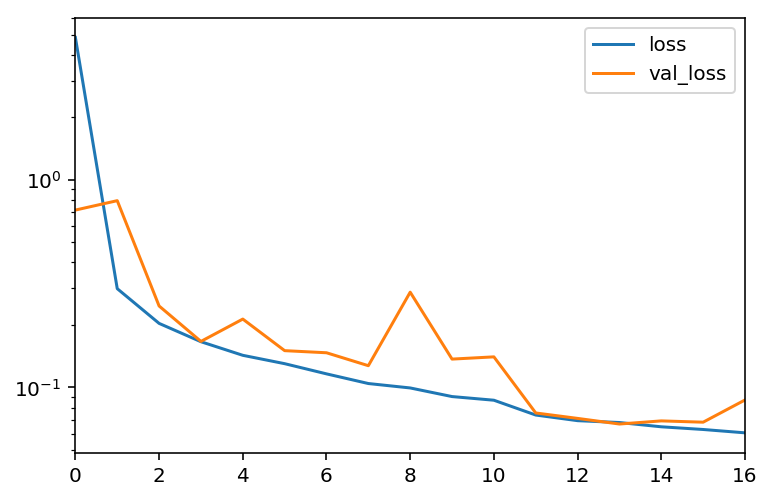

In [16]:
df[['loss', 'val_loss']].plot(logy=True)